# Time-Travel Validation Experiment

This notebook implements a *Time-Travel Validation* strategy to verify the predictive power of the Neurosurgery Knowledge Graph.

**Hypothesis**: A model trained on scientific literature from the past (e.g., up to 2015) should be able to predict medical relationships that were only discovered or validated in later years (e.g., 2016-2024).

**Methodology**:
1.  **Temporal Splitting**: We extract publication years from filenames (e.g., `paper_2010.pdf`) and split the corpus into *Past* and *Future* sets.
2.  **Differential Graph Construction**: We build a graph `G_past` using only the *Past* documents.
3.  **Model Training**: We train our Graph Convolutional Network (GCN) on `G_past` to learn topological and semantic patterns.
4.  **Prediction**: We ask the model to predict missing links in `G_past`.
5.  **Validation**: We check if these predicted links appear as actual, explicit connections in the *Future* documents (`G_future`).

In [1]:
# Imports and Setup
import os
import re
import json
import hashlib
import numpy as np
import pandas as pd # Improved reporting
import networkx as nx
import matplotlib.pyplot as plt
import pickle # Caching
from pathlib import Path
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score, confusion_matrix
import fitz  # PyMuPDF for PDF reading

# Check for PyTorch Geometric and install if missing
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
    from torch_geometric.transforms import RandomLinkSplit
    print("✅ PyTorch Geometric loaded.")
except ImportError:
    import torch
    print(f"⚠️ PyTorch Geometric not found. Installing for Torch {torch.__version__}...")
    print("⏳ Downloading pre-built wheels (this fixes Windows build errors)...")
    
    # Use pre-built wheels to avoid compiling C++ extensions locally
    # We use the exact torch version to find the compatible wheels
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-geometric
    
    # Re-import after install
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
    from torch_geometric.transforms import RandomLinkSplit

from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import spacy

# Load NLP Models
try:
    nlp = spacy.load("es_core_news_lg")
except OSError:
    print("⚠️ Spacy model 'es_core_news_lg' not found. Please download it.")
    # !python -m spacy download es_core_news_lg

print("✅ Setup Complete.")

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ PyTorch Geometric loaded.
✅ Setup Complete.


In [2]:
# ==========================================
# 1. MODEL & HELPERS
# ==========================================

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.3)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=-1)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean': return focal_loss.mean()
        else: return focal_loss.sum()

def prepare_gcn_data(G):
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    idx_to_node = {i: node for node, i in node_to_idx.items()}
    num_nodes = len(node_list)
    
    # Random features
    node_features = torch.randn((num_nodes, 128))
    
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
    
    if not edge_index:
        return None, None, None

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    data = Data(x=node_features, edge_index=edge_index, num_nodes=num_nodes)
    return data, node_to_idx, idx_to_node

def check_dependency(token1, token2):
    if token1 in token2.ancestors or token2 in token1.ancestors: return True
    if token1.head == token2.head and token1.head.pos_ in ["VERB", "AUX"]: return True
    return False

STOPWORDS = {"introducción", "método", "resultados", "conclusión", "figura", "tabla", "estudio"}
ENGLISH_STOPWORDS = {"the", "of", "and", "in", "study"}
STOPWORDS.update(ENGLISH_STOPWORDS)
# Add Spacy defaults if available to remove 'este', 'otro', etc. from graph
try:
    import spacy
    nlp_tmp = spacy.blank("es")
    STOPWORDS.update(nlp_tmp.Defaults.stop_words)
except:
    pass

In [3]:
# ==========================================
# 2. UTILS: CACHING & VISUALIZATION (NEW)
# ==========================================

CACHE_DIR = Path("../cache/graphs")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def get_cache_path(texts_list_hash):
    return CACHE_DIR / f"graph_{texts_list_hash}.pkl"

def hash_texts(texts_list):
    """Creates a unique hash for a list of texts to identify the dataset version."""
    content = "".join(sorted(texts_list))
    return hashlib.md5(content.encode('utf-8')).hexdigest()[:12]

def save_graph_cache(G, texts_hash):
    with open(get_cache_path(texts_hash), "wb") as f:
        pickle.dump(G, f)

def load_graph_cache(texts_hash):
    path = get_cache_path(texts_hash)
    if path.exists():
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def visualize_prediction_subgraph(G, source, target, score, year):
    """Visualizes the local neighborhood of a predicted link."""
    nodes = set([source, target])
    # Add neighbors
    if source in G: nodes.update(list(G.neighbors(source))[:3])
    if target in G: nodes.update(list(G.neighbors(target))[:3])
    
    subgraph = G.subgraph(list(nodes))
    
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', 
            node_size=800, font_size=8, edge_color='gray')
    
    # Highlight predicted edge
    plt.plot([pos[source][0], pos[target][0]], [pos[source][1], pos[target][1]], 
             color='red', linestyle='--', linewidth=2, label=f'Pred: {score:.2f}')
    
    plt.title(f"Prediction for {year}: {source} -- {target}")
    plt.legend()
    plt.show()

In [4]:
# ==========================================
# 3. DATA LOADING & PROCESSING
# ==========================================

def extract_year_from_filename(filename):
    match = re.search(r'(19|20)\d{2}', filename)
    if match: return int(match.group(0))
    return None

def read_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        full_text = []
        for page in doc: full_text.append(page.get_text())
        return "\n".join(full_text)
    except: return ""

def load_corpus_by_year(corpus_path="../corpus", txts_path="../txts"):
    corpus_path = Path(corpus_path)
    txts_path = Path(txts_path)
    
    if not corpus_path.exists():
        print(f"❌ Path not found: {corpus_path}")
        return {}, []
    
    if not txts_path.exists(): txts_path.mkdir(parents=True, exist_ok=True)
    
    docs_by_year = defaultdict(list)
    print(f"📂 Scanning {corpus_path}...")
    
    processed = 0
    for pdf in corpus_path.glob("*.pdf"):
        txt = txts_path / pdf.with_suffix(".txt").name
        text = ""
        if txt.exists():
            with open(txt, "r", encoding="utf-8", errors="ignore") as f: text = f.read()
        else:
            text = read_pdf(pdf)
            if text.strip():
                with open(txt, "w", encoding="utf-8") as f: f.write(text)
        
        if not text.strip(): continue
        year = extract_year_from_filename(pdf.name)
        if year: docs_by_year[year].append(text)
        processed += 1
        
    return docs_by_year, sorted(docs_by_year.keys())

def build_graph_from_texts(texts_list, ner_pipeline, nlp_model):
    """Builds graph with caching support."""
    texts_hash = hash_texts(texts_list)
    
    # Try loading from cache
    cached_G = load_graph_cache(texts_hash)
    if cached_G:
        print(f"  ⚡ Loaded graph from cache ({len(cached_G.nodes())} nodes)")
        return cached_G

    # Build from scratch
    print(f"  🏗️ Building graph from scratch (No cache found)...")
    G = nx.Graph()
    combined_text = "\n".join(texts_list)
    sentences = [s for s in combined_text.split('.') if len(s) > 20]
    
    for s in sentences[:3000]: # Limit for speed
        try:
            ner_results = ner_pipeline(s)
            if not ner_results: continue
            
            entities = []
            seen_lemmas = set()
            doc = nlp_model(s)
            
            for ent in ner_results:
                if ent['score'] < 0.60: continue
                span = doc.char_span(ent['start'], ent['end'], alignment_mode="contract")
                lemma = unidecode(" ".join([t.lemma_.lower() for t in span])).strip() if span else unidecode(ent['word'].lower()).strip()
                lemma = re.sub(r'[^\w\s]', '', lemma)
                if len(lemma) > 3 and lemma not in STOPWORDS and lemma not in seen_lemmas:
                    entities.append({'lemma': lemma, 'span': span})
                    seen_lemmas.add(lemma)
            
            if len(entities) < 2: continue
            for e1, e2 in combinations(entities, 2):
                weight = 1
                G.add_edge(e1['lemma'], e2['lemma'], weight=weight)
        except: continue
    
    # Save to cache
    save_graph_cache(G, texts_hash)
    return G

# Init Pipeline
from unidecode import unidecode
model_name = "HUMADEX/spanish_medical_ner"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="max")

docs_by_year, sorted_years = load_corpus_by_year(corpus_path="../corpus", txts_path="../txts")

Device set to use cpu


📂 Scanning ..\corpus...



🔄 ROLLING ANALYSIS WITH CACHING & VISUALIZATION

📅 Simulating Year: 2008
  ⚡ Loaded graph from cache (1312 nodes)
  ⚡ Loaded graph from cache (3815 nodes)
  ✅ Accuracy for 2008: 6.00%

📅 Simulating Year: 2009
  ⚡ Loaded graph from cache (1570 nodes)
  ⚡ Loaded graph from cache (3769 nodes)
  ✅ Accuracy for 2009: 21.50%

📅 Simulating Year: 2010
  ⚡ Loaded graph from cache (1848 nodes)
  ⚡ Loaded graph from cache (3555 nodes)
  ✅ Accuracy for 2010: 11.00%

📅 Simulating Year: 2012
  ⚡ Loaded graph from cache (2676 nodes)
  ⚡ Loaded graph from cache (3267 nodes)
  ✅ Accuracy for 2012: 13.00%

📅 Simulating Year: 2013
  ⚡ Loaded graph from cache (2973 nodes)
  ⚡ Loaded graph from cache (3179 nodes)
  ✅ Accuracy for 2013: 20.50%

📅 Simulating Year: 2014
  ⚡ Loaded graph from cache (3444 nodes)
  ⚡ Loaded graph from cache (3103 nodes)
  ✅ Accuracy for 2014: 18.00%

📅 Simulating Year: 2016
  ⚡ Loaded graph from cache (3689 nodes)
  ⚡ Loaded graph from cache (2988 nodes)
  ✅ Accuracy for 2016: 

,Training_Year,Source,Target,Score,Rank
880,2013,endoscopico,selar,32.747398,81
898,2013,endoscopico,campimetrico,31.645872,99
900,2013,endoscopico,visual,31.603357,101
940,2013,crecimiento,selar,30.342041,141
1830,2020,endoscopico,crecimiento,23.688414,31
215,2009,prolactina,transesfenoidal,22.687227,16
1853,2020,craneofaringiomas,macroadenoma,22.347273,54
1857,2020,endoscopico,visual,22.013039,58
1862,2020,total,transcraneal,21.897072,63
1863,2020,endoscopico,morbilidad,21.872517,64



📝 RAW TOP HITS (Including Generics)


,Training_Year,Source,Target,Score,Rank
1800,2020,lesion,adenoma hipofisario,48.266617,1
803,2013,quirurgico,tumoral,41.522125,4
2200,2022,lesion,adenoma hipofisario,41.254356,1
804,2013,region,tratamiento,41.161030,5
806,2013,endoscopico,otro,40.383778,7
807,2013,cirugia,selar,40.266769,8
813,2013,tratamiento,selar,38.890896,14
201,2009,lesion,ameijeiras,37.913662,2
840,2013,este,campimetrico,35.719513,41
843,2013,este,sintoma,35.369339,44


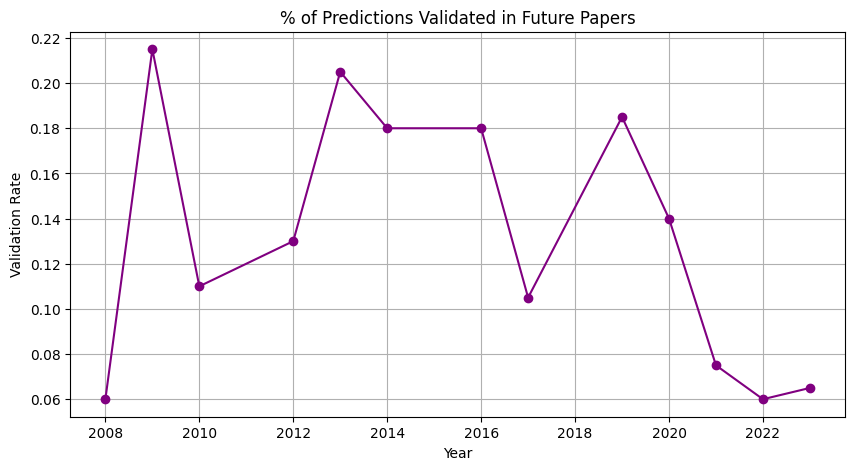

In [5]:
# ==========================================
# 4. IMPROVED TRAIN & PREDICT
# ==========================================

def train_and_predict(G_train, top_k=50):
    data, node_to_idx, idx_to_node = prepare_gcn_data(G_train)
    if data is None: return []
    
    transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
    train_data, val_data, test_data = transform(data)
    
    model = GCNLinkPredictor(128, 256, 128)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = FocalLoss(alpha=1, gamma=2)
    
    print("  • Training GCN (Silent)...", end="\r")
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)
        
        neg_edge_index = torch.randint(0, data.num_nodes, (2, train_data.edge_label_index.size(1)))
        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=1)
        edge_label = torch.cat([train_data.edge_label, torch.zeros(neg_edge_index.size(1))], dim=0)
        
        out = model.decode(z, edge_label_index)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        predictions = []
        
        nodes = list(G_train.nodes())
        top_nodes = sorted(nodes, key=lambda n: G_train.degree(n), reverse=True)[:200]
        
        for i, u in enumerate(top_nodes):
             for v in top_nodes[i+1:]:
                if not G_train.has_edge(u, v):
                    idx_u, idx_v = node_to_idx[u], node_to_idx[v]
                    score = (z[idx_u] * z[idx_v]).sum().item()
                    predictions.append((u, v, score))
    
    predictions.sort(key=lambda x: x[2], reverse=True)
    return predictions[:top_k]

if sorted_years and len(sorted_years) > 3:
    print("\n🔄 ROLLING ANALYSIS WITH CACHING & VISUALIZATION")
    print("="*60)
    
    all_detailed_predictions = []
    years_to_scan = [y for y in sorted_years if y > sorted_years[2] and y < sorted_years[-1]]
    cumulative_docs = []
    
    for y in sorted_years:
        if y < years_to_scan[0]: cumulative_docs.extend(docs_by_year[y])

    for year in years_to_scan:
        print(f"\n📅 Simulating Year: {year}")
        cumulative_docs.extend(docs_by_year[year])
        
        future_docs = []
        for fy in sorted_years:
            if fy > year: future_docs.extend(docs_by_year[fy])
        if not future_docs: break
        
        # Build Graphs with Cache
        G_now = build_graph_from_texts(cumulative_docs, ner_pipeline, nlp)
        G_future = build_graph_from_texts(future_docs, ner_pipeline, nlp)
        
        # Save Hash Mapping for Viz App
        from pathlib import Path
        import json
        
        current_hash = hash_texts(cumulative_docs)
        map_path = Path("../cache/year_map.json")
        if map_path.exists():
            with open(map_path, "r") as f: year_map = json.load(f)
        else:
            year_map = {}
        
        year_map[str(year)] = current_hash
        with open(map_path, "w") as f: json.dump(year_map, f)
        
        # Predict (Increased top_k for better filtering)
        preds = train_and_predict(G_now, top_k=200)
        
        # Validate & Record
        future_edges = set([frozenset([u,v]) for u,v in G_future.edges()])
        
        hit_count = 0
        for i, (u, v, score) in enumerate(preds):
            verified = frozenset([u,v]) in future_edges
            if verified: hit_count += 1
            
            # Record detailed row
            all_detailed_predictions.append({
                'Training_Year': year,
                'Source': u,
                'Target': v,
                'Score': score,
                'Verified_Later': verified,
                'Rank': i+1
            })

        print(f"  ✅ Accuracy for {year}: {hit_count/200:.2%}")

    # Final Report
    print("\n" + "="*60)
    print("📊 DETAILED REPORT GENERATION (Refined)")
    print("="*60)
    
    # Generic terms to filter out from "Top Predictions" to show more interesting medical links
    REPORTING_BLACKLIST = {
        "lesion", "tumor", "tumoral", "paciente", "tratamiento", "cirugia", 
        "quirurgico", "caso", "estudio", "hospital", "ameijeiras", "clinico", 
        "resultados", "conclusion", "metodo", "objetivo", "discusion", "figura",
        "tabla", "analisis", "significativo", "embargo", "pacientes", "embargo",
        "secretor", "secretora", "grado", "grados", "grupo", "años", "edad",
        "sintoma", "este", "region", "evaluacion", "otro", "abordaje", "complicacion",
        "defecto", "hormonal", "tipo", "parte", "forma", "nivel", "zona", "area"
    }
    
    df = pd.DataFrame(all_detailed_predictions)
    
    # SAVE DATA FOR VIZ APP
    df.to_csv("../cache/predictions_history.csv", index=False)
    print(f"💾 Saved predictions to ../cache/predictions_history.csv")
    
    # Filter hits
    if not df.empty:
        df_hits = df[df['Verified_Later'] == True].copy()
        
        # Apply Blacklist Filter for the "Interesting" view
        mask = df_hits.apply(lambda x: x['Source'] not in REPORTING_BLACKLIST and x['Target'] not in REPORTING_BLACKLIST, axis=1)
        df_interesting = df_hits[mask]
        
        print("\n🏆 TOP VERIFIED PREDICTIONS (Filtered for Medical Specificity)")
        if not df_interesting.empty:
            display(df_interesting[['Training_Year', 'Source', 'Target', 'Score', 'Rank']].sort_values(by='Score', ascending=False).head(20))
        else:
            print("No interesting hits found after filtering generic terms. Try increasing top_k.")
            
        print("\n📝 RAW TOP HITS (Including Generics)")
        display(df_hits[['Training_Year', 'Source', 'Target', 'Score', 'Rank']].sort_values(by='Score', ascending=False).head(10))
        
        # Summary Plot
        summary = df.groupby('Training_Year')['Verified_Later'].mean().reset_index()
        plt.figure(figsize=(10, 5))
        plt.plot(summary['Training_Year'], summary['Verified_Later'], marker='o', color='purple')
        plt.title('% of Predictions Validated in Future Papers')
        plt.xlabel('Year')
        plt.ylabel('Validation Rate')
        plt.grid(True)
        plt.show()
    else:
        print("No hits verified yet based on current data.")